# Make plots for nesting movies

This code makes nesting movies, starting at the PACBIG grid, going to the WHITESHARK grid, and onwards


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
#import cv2
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
import os
#import gsw

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


In [2]:
# Load PACBIG
file = '/data/thomas/bdelorme/PACBIG/pacbig_grd_nw_dig.nc'
pacbiggrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/bdelorme/PACBIG/'
dspacbig = xr.open_mfdataset(filelocation+'*his*.nc', concat_dim='time',data_vars='minimal')
pacbigyearday = np.mod(dspacbig.ocean_time/86400, 360)

In [3]:
# Load WHITESHARK grid file
file = '/data/thomas/jacob13/WHITESHARKCAFE/WHITESHARK/whiteshark_grd.nc'
whitesharkgrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/jacob13/WHITESHARKCAFE/WHITESHARK/'
dswhiteshark= xr.open_mfdataset(filelocation+'whiteshark_his*.nc', concat_dim='time', data_vars='minimal', compat='equals')
#dschesa= xr.open_dataset(filelocation+'chesa2_his.0096.nc')
whitesharkyearday = np.mod(dswhiteshark.scrum_time/86400, 360)

In [4]:
# Load MSHARK grid file
file = '/data/thomas/jacob13/WHITESHARKCAFE/MSHARKNP/mshark_grd.nc'
msharkgrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/jacob13/WHITESHARKCAFE/MSHARKNP/'
dsmshark= xr.open_mfdataset(filelocation+'mshark_his*.nc', concat_dim='time', data_vars='minimal', compat='equals')
#dsmshark = xr.open_dataset(filelocation+'mshark_his.0000.nc')
msharkyearday = np.mod(dsmshark.scrum_time/86400, 360)

In [2]:
# Load BSHARK grid file
file = '/data/thomas/jacob13/WHITESHARKCAFE/BSHARK/bshark_grd.nc'
bsharkgrid = xr.open_dataset(file)

# Load files (concatenate across all files)
filelocation = '/data/thomas/jacob13/WHITESHARKCAFE/BSHARK/'
dsbshark= xr.open_mfdataset(filelocation+'bshark_his*.nc', concat_dim='time', data_vars='minimal', compat='equals')
#dsmshark = xr.open_dataset(filelocation+'mshark_his.0000.nc')
bsharkyearday = np.mod(dsbshark.scrum_time/86400, 360)

In [25]:
msharkyearday.values[170]
#test = xr.open_dataset(filelocation+'mshark_his.0180.nc')
#np.mod(test.scrum_time/86400, 360).values
msharkyearday.values[170]
test.scrum_time.values[0]/86400

3265.0

In [6]:
def calcRelVort(pltdatau, pltdatav, griddata):
    #pltdatau = dsgulfz.u.isel(time=ti, s_rho =slevel)
    #pltdatav = dsgulfz.v.isel(time=ti, s_rho =slevel)

    uy = pltdatau.diff('eta_rho').values*griddata.pn[:-1,:-1]#*0.5*(gulfzgrid.pn[:,1:] + gulfzgrid.pn[:,:-1])
    uy = 0.5*(uy[1:,:] + uy[:-1,:])
#vx = np.gradient(pltdatav.values, axis=1)*0.5*(gulfzgrid.pm[1:,:] + gulfzgrid.pm[:-1,:])
    vx = pltdatav.diff('xi_rho').values*griddata.pm[:-1,:-1]
    
    zeta = vx[:-1,:]-uy
    
    #zeta[1:-1,1:-1] = 0.25*(zeta[1:,:] + zeta[:-1,:] + zeta[:,1:] + zeta[:,:-1])
    cori = 2*2*np.pi/86400*np.sin(griddata.lat_rho*np.pi/180)
    #cori = 0.25*(cori[1:,:] + cori[:-1,:] + cori[:,1:] + cori[:,:-1])
    #print(zeta.shape)
    #print(cori.shape)
    zetanorm = zeta/cori[1:-1,:-1]
    ny, nx = griddata.pm.shape
    temp = 0*np.zeros((ny, nx))
    temp[1:-1,1:]  = zetanorm
    return temp


/usr/local/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


NameError: name 'bsharkgrid' is not defined

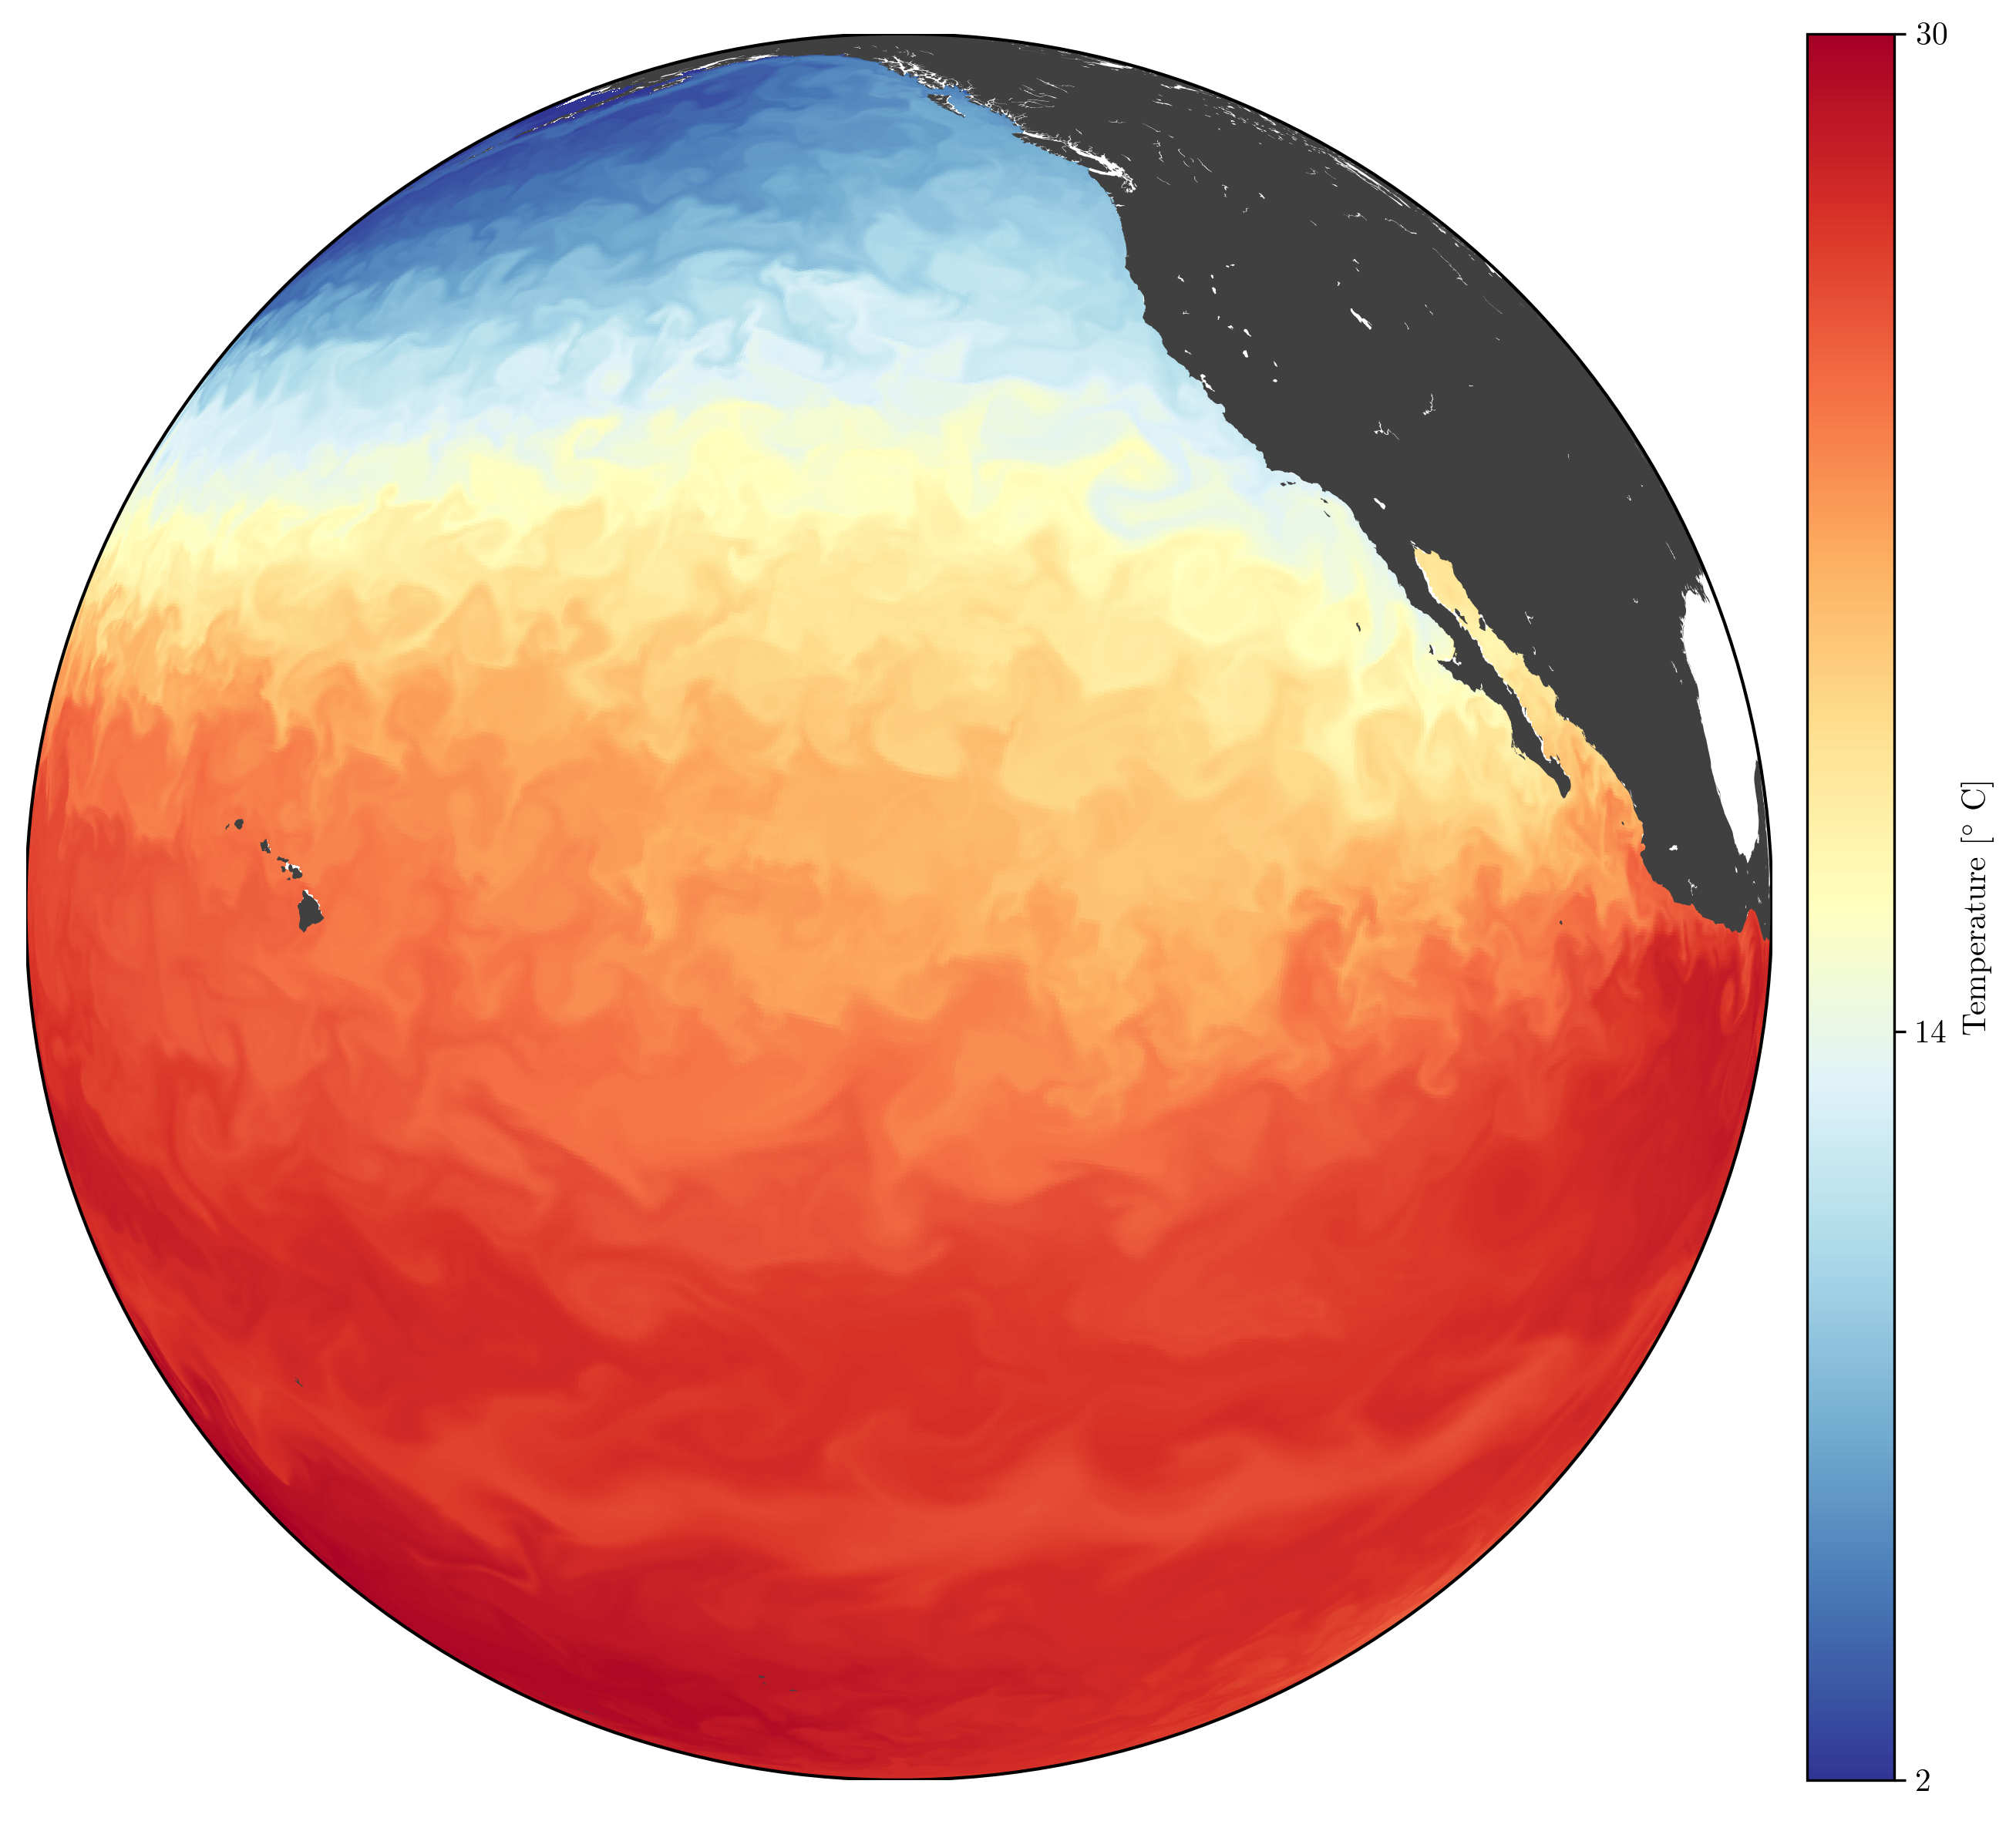

In [7]:
# Make PACBIG outer grid plot
savefig = False
animate= False
vort = False
nest = False
nestb = True

climl = 2
climh = 30
cmap = 'RdYlBu_r'
tag = 'temp'
label = 'Temperature [$^\circ$ C]'
ticks = [climl, (climh-climl)/2, climh]
if vort:
    climl = -1
    climh = 1
    cmap = 'seismic'
    tag = 'vort'
    label = 'Rossby Number [$\zeta/f$]'
    ticks = [int(climl), 0, int(climh)]
    
slevel = 49
tistart = 125+5

nt = dspacbig.time.shape[0]
if animate:
    trange = range(0, nt)
    #trange = range(0, tistart)
else:
    trange = range(tistart,tistart+1)

counter = 0
for ti in trange:
    pltdata = dspacbig.temp.isel(time=ti, s_rho=slevel)
    pltdata = pltdata.where(pltdata>0)
    if vort:
        pltdata = calcRelVort(dspacbig.u.isel(time=ti, s_rho=slevel), dspacbig.v.isel(time=ti, s_rho=slevel), pacbiggrid)
    #pltdata = pltdata.to_masked_ar
    #dsgulfz.to_array
    plt.figure(figsize=(15, 10), dpi=300)
    #m = Basemap(projection='cyl',llcrnrlat=np.min(pacbiggrid.lat_rho.values),urcrnrlat=np.max(pacbiggrid.lat_rho.values),\
    #            llcrnrlon=np.min(pacbiggrid.lon_rho.values),urcrnrlon=np.max(pacbiggrid.lon_rho.values),lat_ts=5,resolution='l')
    #m = Basemap(projection='ortho',lon_0=-160,lat_0 = 10,resolution='l')
    m = Basemap(projection='nsper',lon_0 = -135, lat_0 = 21, satellite_height=3000*1000, resolution='i')

    #m.drawcoastlines()
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    #m.drawparallels(np.arange(-90.,91.,10.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmeridians(np.arange(-180.,181.,20.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    m.pcolor(pacbiggrid.lon_rho.values, pacbiggrid.lat_rho.values, pltdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)
    if nest:
        wsones = 1 + 0*msharkgrid.lat_rho.values
        wsones[0,:] = 0
        wsones[-1,:] = 0
        wsones[:,0] = 0
        wsones[:,-1] = 0
        m.contour(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, wsones,[0, 1], colors='k', latlon=True)#'#ff7f0e'
    if nestb:
        wsones = 1 + 0*bsharkgrid.lat_rho.values
        wsones[0,:] = 0
        wsones[-1,:] = 0
        wsones[:,0] = 0
        wsones[:,-1] = 0
        m.contour(bsharkgrid.lon_rho.values, bsharkgrid.lat_rho.values, wsones,[0, 1], colors='k', latlon=True)#'#ff7f0e'
    #m.contour(chesagrid.lon_rho.values, chesagrid.lat_rho.values, chesaones,[0, 1], colors='g', latlon=True, linestyles='dotted')
    plt.title("12 km resolution,      yearday: {}".format(str(int(np.floor(pacbigyearday.values[ti])))))
    
    if savefig:
        plt.savefig('./'+tag+'_{}.png'.format(str(int(counter))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
    counter += 1

#ffmpeg -framerate 12 -i vort_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978 -vframes 245 zetamov_new.mov


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


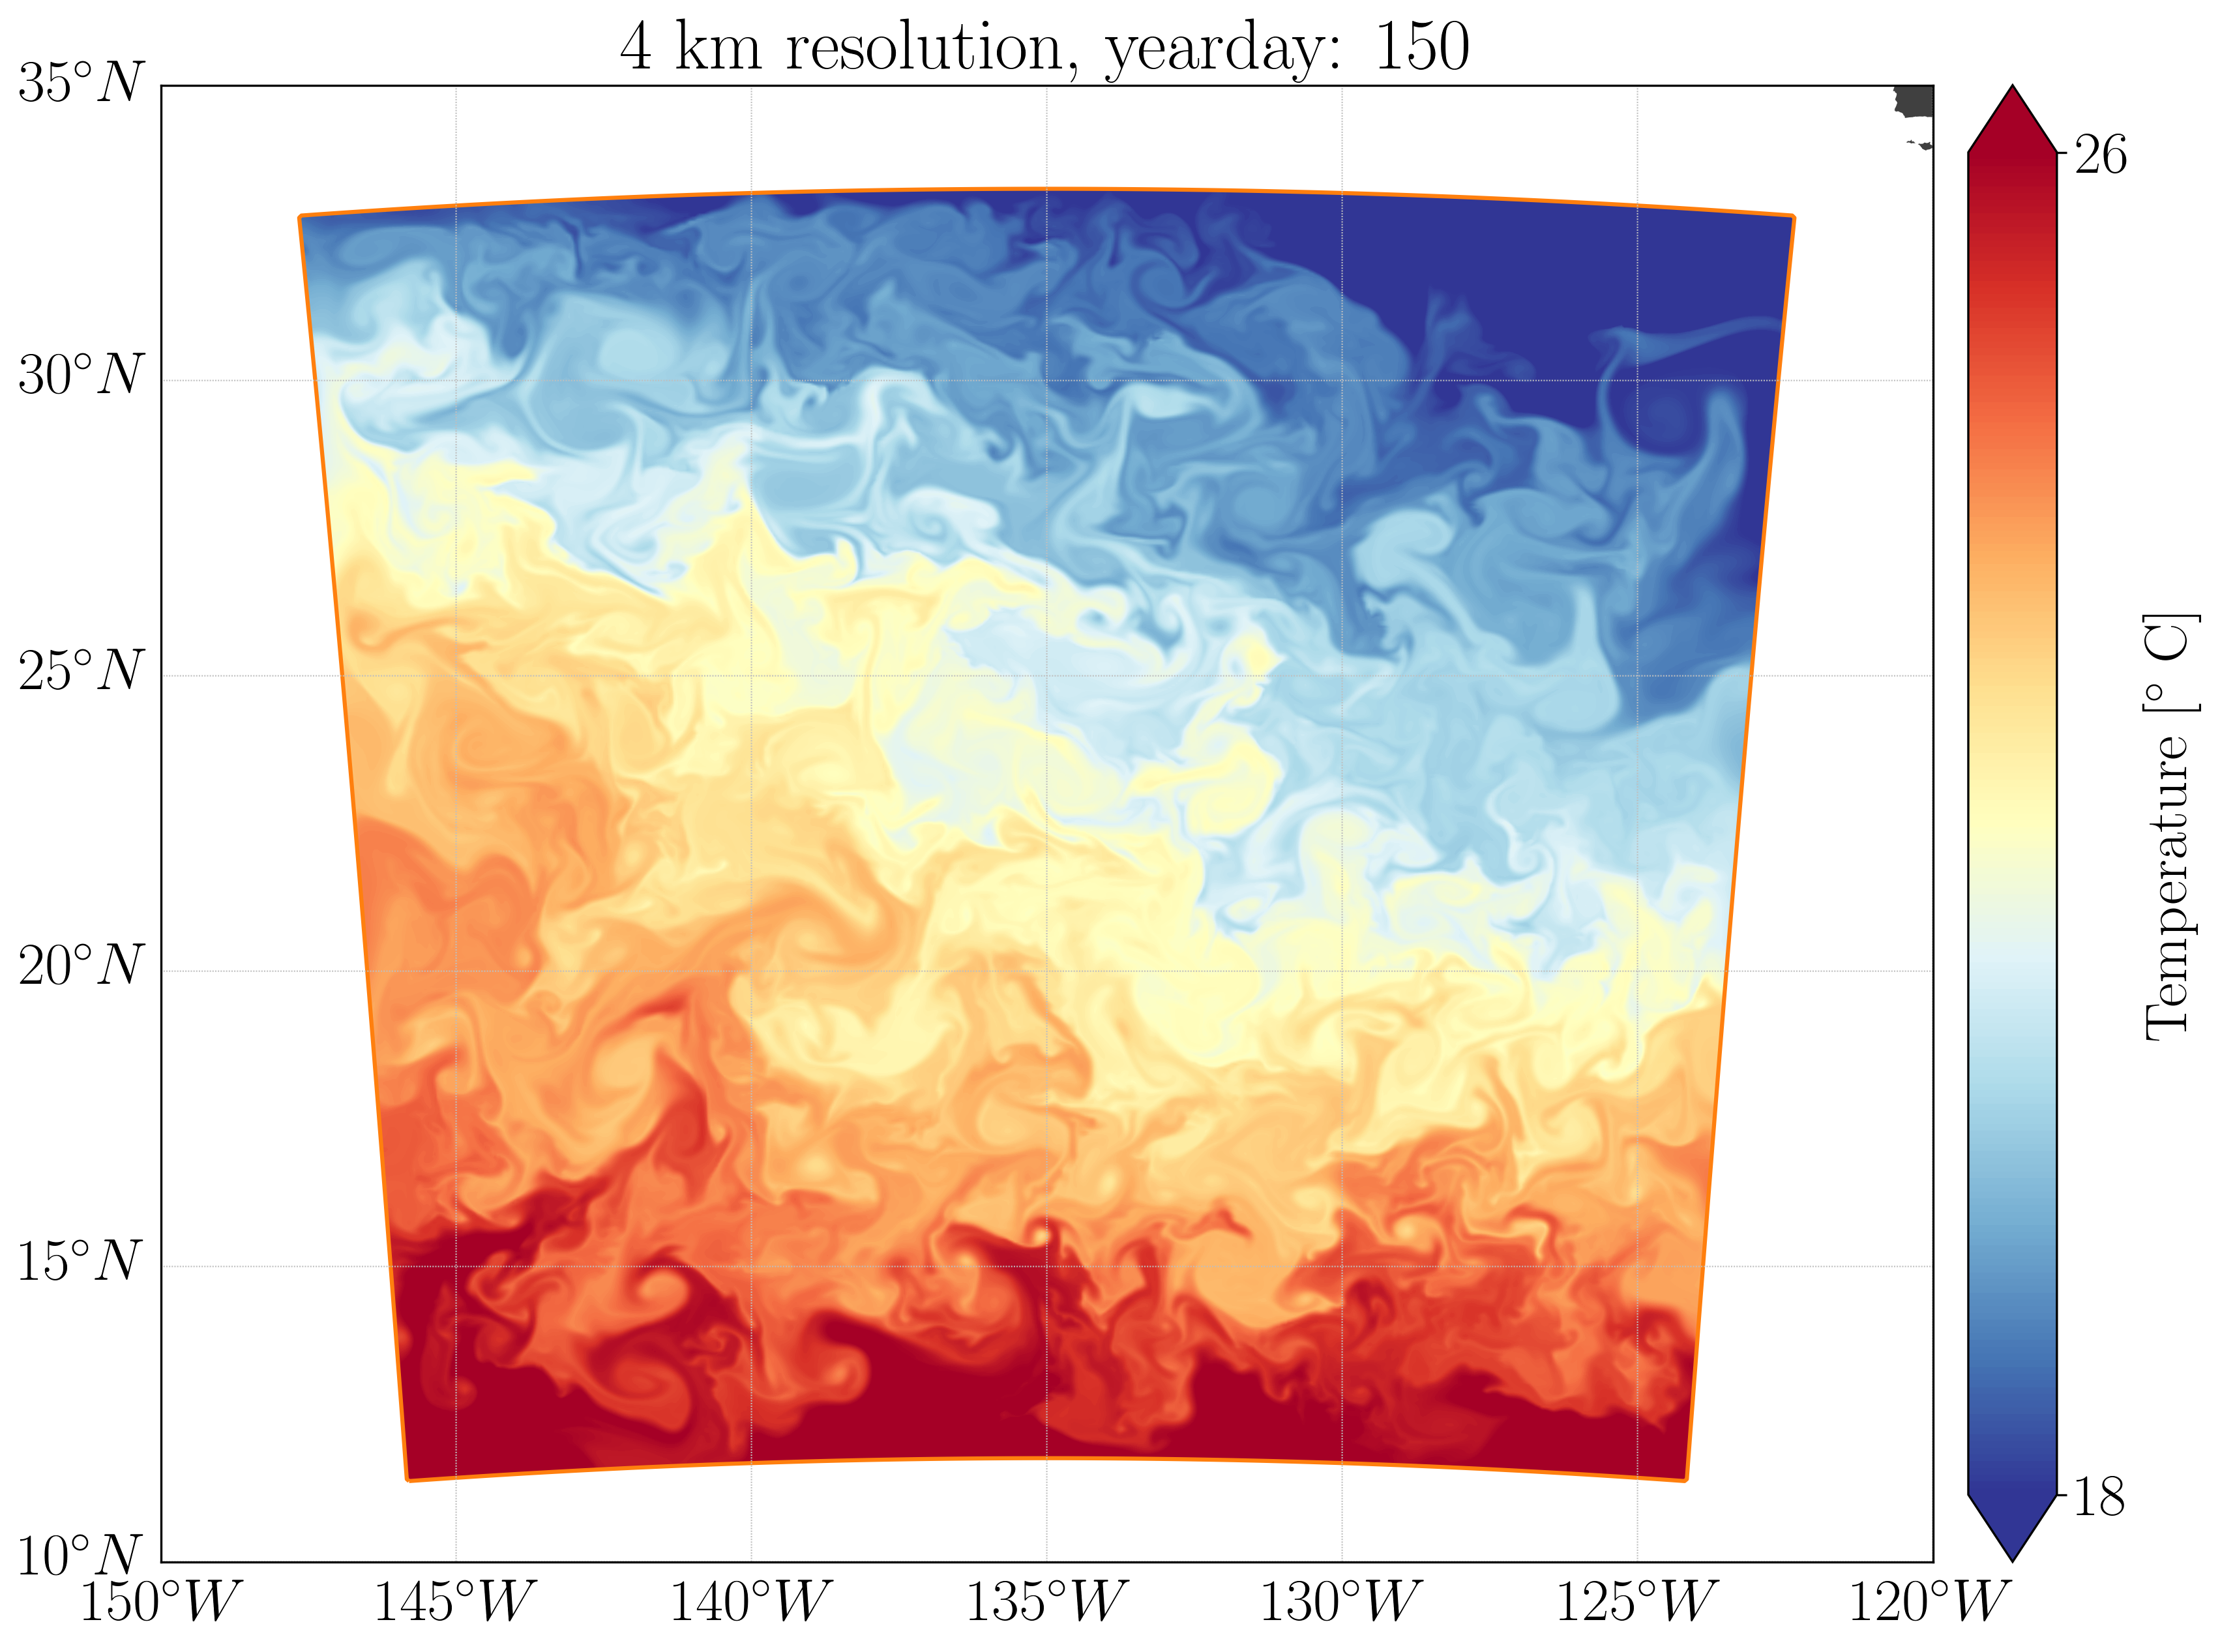

In [30]:
# Make WHITESHARK grid plot
saving = False
parent = False
animate = False
vort = False
nest = False

tistart = np.argmin(np.abs(whitesharkyearday.values - 150))


if vort:
    cmap = 'seismic'
    climl = -1.5
    climh = 1.5
    ticks = [climl, 0, climh]
    label = 'Rossby Number [$\zeta/f$]'
else:
    cmap = 'RdYlBu_r'
    climl = 18
    climh = 26
    ticks = [climl, climh]
    label = 'Temperature [$^{\circ}$ C]'
    
if parent:
    tag = 'PACBIG'
    titletag = '12 km'
    slevel = 49
else:
    tag = 'WHITESHARK'
    titletag = '4 km'
    slevel = 79
    
if not vort:
    tag = tag + '_TEMP'
    
nt = dswhiteshark.time.shape[0]
if animate:
    trange = range(0, nt)
else:
    trange = range(tistart,tistart+1)

conts = np.linspace(climl, climh, 200)

for ti in trange:

    plt.figure(figsize=(15, 10), dpi=300)
    m = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=35,\
                llcrnrlon=-150,urcrnrlon=-120,lat_ts=5,resolution='h')
    #m.drawcoastlines()
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    m.drawmeridians(np.arange(-180.,181.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    #m.pcolormesh(gulfzgrid.lon_rho.values, gulfzgrid.lat_rho.values, gulfzdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    if parent:
        pacbigdata = calcRelVort(dspacbig.u.isel(time=ti, s_rho=slevel), dspacbig.v.isel(time=ti, s_rho=slevel), pacbiggrid)
        m.contourf(pacbiggrid.lon_rho.values, pacbiggrid.lat_rho.values, pacbigdata,conts, latlon=True, extend='both', cmap=cmap)

    if not parent:
        if vort:
            whitesharkdata = calcRelVort(dswhiteshark.u.isel(time=ti, s_rho=slevel), dswhiteshark.v.isel(time=ti, s_rho=slevel), whitesharkgrid)
        else:
            whitesharkdata = dswhiteshark.temp.isel(time=ti, s_rho = slevel)
            whitesharkdata = whitesharkdata.where(whitesharkdata>0)
        #chesadata = dschesa.temp.isel(time=ti, s_rho=slevel)
        m.contourf(whitesharkgrid.lon_rho.values, whitesharkgrid.lat_rho.values, whitesharkdata, conts, latlon=True, cmap=cmap, extend='both')


    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)

    chesaones = 1 + 0*whitesharkgrid.lat_rho.values
    chesaones[0,:] = 0
    chesaones[-1,:] = 0
    chesaones[:,0] = 0
    chesaones[:,-1] = 0
    m.contour(whitesharkgrid.lon_rho.values, whitesharkgrid.lat_rho.values, chesaones,[0, 1], colors='#ff7f0e', latlon=True)

    if nest:
        chesaones = 1 + 0*babysharkgrid.lat_rho.values
        chesaones[0,:] = 0
        chesaones[-1,:] = 0
        chesaones[:,0] = 0
        chesaones[:,-1] = 0
        m.contour(babysharkgrid.lon_rho.values, babysharkgrid.lat_rho.values, chesaones,[0, 1], colors='k', latlon=True)


    plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(whitesharkyearday.values[ti])))))

    if saving:
        plt.savefig('/data/thomas/jacob13/WHITESHARKCAFE/WHITESHARK/Figs/'+tag+'_{}.png'.format(str(int(ti))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        
#ffmpeg -start_number 96 -framerate 12 -i CHESA2MOV_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  chesa.mov
#ffmpeg -start_number 0 -framerate 15 -i WHITESHARK_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  whiteshark.mov

In [27]:
tistart

<xarray.DataArray 'scrum_time' ()>
dask.array<shape=(), dtype=int64, chunksize=()>

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


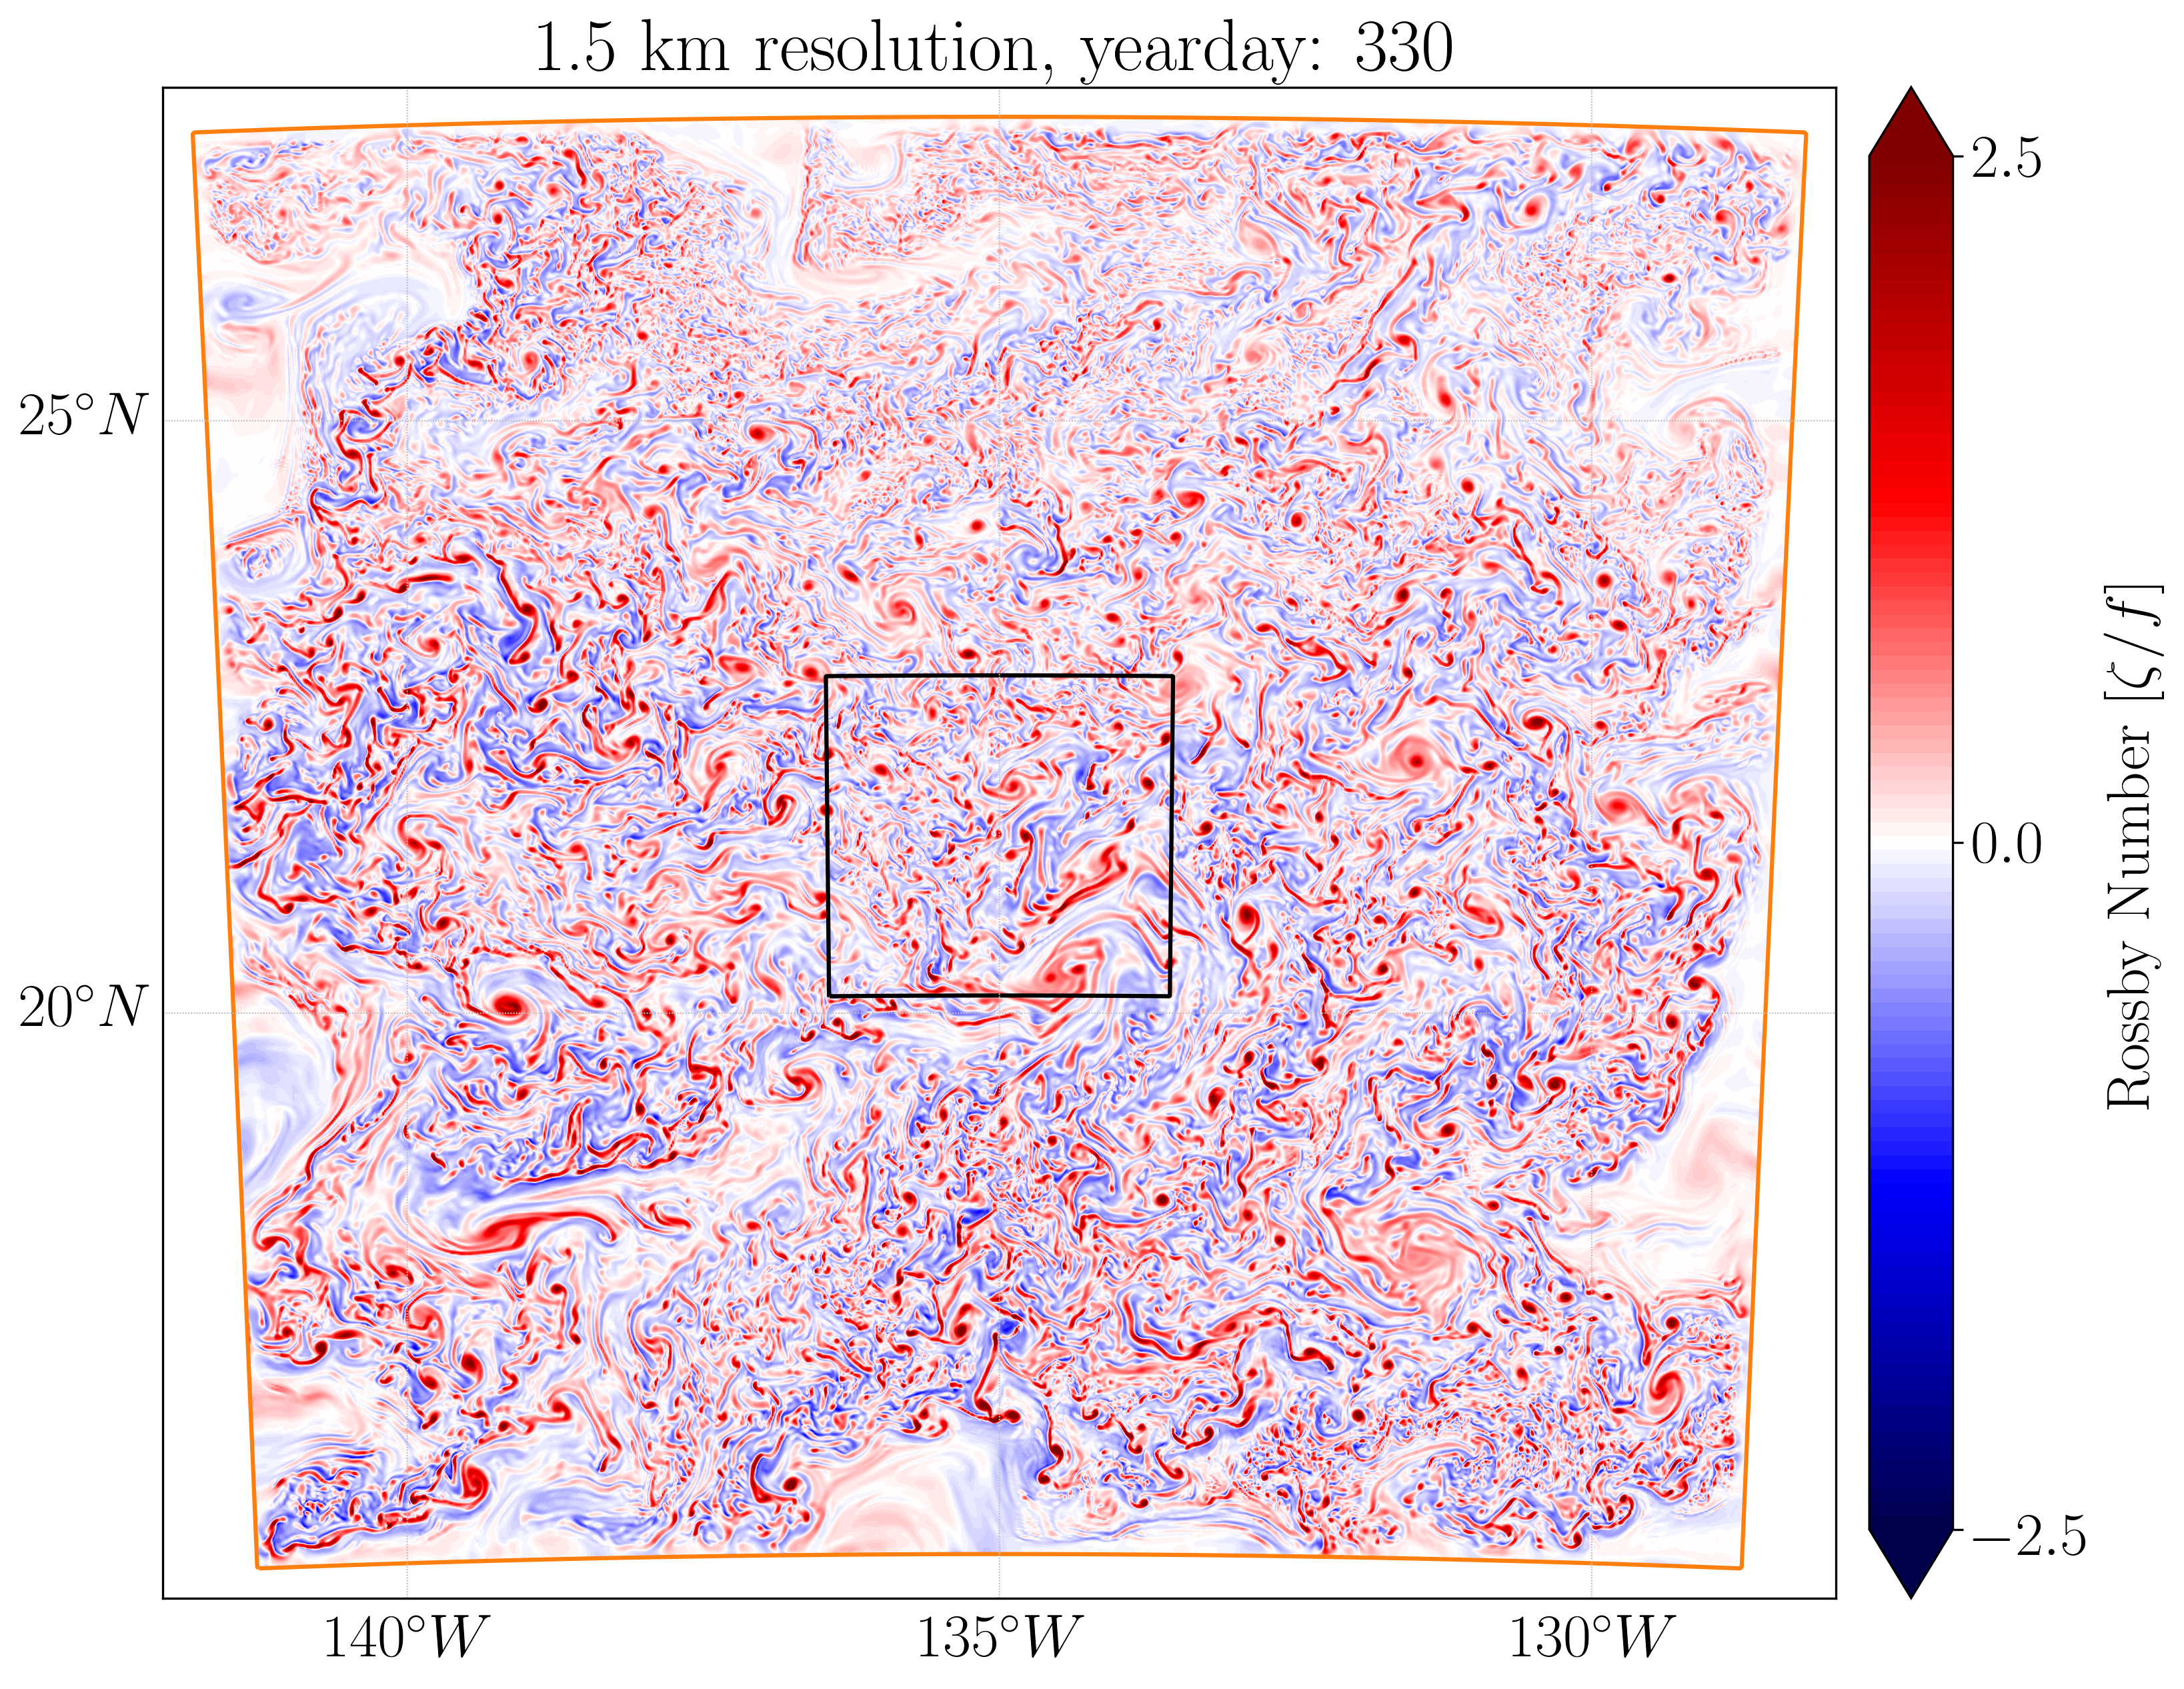

In [78]:
# Make MSHARK grid plot
saving = False
parent = False
animate = False
vort = True
nest = True

tistart = np.argmin(np.abs(msharkyearday.values - 330))


if vort:
    cmap = 'seismic'
    climl = -2.5
    climh = 2.5
    ticks = [climl, 0, climh]
    label = 'Rossby Number [$\zeta/f$]'
else:
    cmap = 'RdYlBu_r'
    climl = 19
    climh = 25
    ticks = [climl, climh]
    label = 'Temperature [$^{\circ}$ C]'
    
if parent:
    tag = 'WHITESHARK'
    titletag = '4 km'
    slevel = 49
else:
    tag = 'MSHARK'
    titletag = '1.5 km'
    slevel = 79
    
if not vort:
    tag = tag + '_TEMP'
    
nt = dsmshark.time.shape[0]
if animate:
    trange = range(tistart, tistart+160)
else:
    trange = range(tistart,tistart+1)

conts = np.linspace(climl, climh, 100)

for ti in trange:

    plt.figure(figsize=(15, 10), dpi=300)
    offset = 0.25
    m = Basemap(projection='cyl',llcrnrlat=np.min(msharkgrid.lat_rho.values)-offset,urcrnrlat=np.max(msharkgrid.lat_rho.values)+offset,\
                llcrnrlon=np.min(msharkgrid.lon_rho.values)-offset,urcrnrlon=np.max(msharkgrid.lon_rho.values)+offset,lat_ts=5,resolution='c')
    #m = Basemap(projection='nsper',lon_0 = -135, lat_0 = 21, satellite_height=300*1000)
    #m = Basemap(projection='cea',llcrnrlat=np.min(msharkgrid.lat_rho.values)-1,urcrnrlat=np.max(msharkgrid.lat_rho.values)+1,\
    #            llcrnrlon=np.min(msharkgrid.lon_rho.values)-1,urcrnrlon=np.max(msharkgrid.lon_rho.values)+1,lat_ts=22,resolution='c')
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    m.drawmeridians(np.arange(-180.,181.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    #m.pcolormesh(gulfzgrid.lon_rho.values, gulfzgrid.lat_rho.values, gulfzdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    if parent:
        parentdata = calcRelVort(dswhiteshark.u.isel(time=ti, s_rho=slevel), dswhiteshark.v.isel(time=ti, s_rho=slevel), whitesharkgrid)
        m.contourf(whitesharkgrid.lon_rho.values, whitesharkgrid.lat_rho.values, parentdata,conts, latlon=True, extend='both', cmap=cmap)

    if not parent:
        if vort:
            msharkdata = calcRelVort(dsmshark.u.isel(time=ti, s_rho=slevel), dsmshark.v.isel(time=ti, s_rho=slevel), msharkgrid)
        else:
            msharkdata = dsmshark.temp.isel(time=ti, s_rho = slevel)
            msharkdata = msharkdata.where(msharkdata>0)
        #chesadata = dschesa.temp.isel(time=ti, s_rho=slevel)
        m.contourf(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, msharkdata, conts, latlon=True, cmap=cmap, extend='both')


    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)

    chesaones = 1 + 0*msharkgrid.lat_rho.values
    chesaones[0,:] = 0
    chesaones[-1,:] = 0
    chesaones[:,0] = 0
    chesaones[:,-1] = 0
    m.contour(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, chesaones,[0, 1], colors='#ff7f0e', latlon=True)

    if nest:
        chesaones = 1 + 0*bsharkgrid.lat_rho.values
        chesaones[0,:] = 0
        chesaones[-1,:] = 0
        chesaones[:,0] = 0
        chesaones[:,-1] = 0
        m.contour(bsharkgrid.lon_rho.values, bsharkgrid.lat_rho.values, chesaones,[0, 1], colors='k', latlon=True)


    plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(msharkyearday.values[ti])))))

    if saving:
        plt.savefig('/data/thomas/jacob13/WHITESHARKCAFE/MSHARKNP/Figs/'+tag+'_{}.png'.format(str(int(ti))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        
#ffmpeg -start_number 96 -framerate 12 -i CHESA2MOV_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  chesa.mov
#ffmpeg -start_number 0 -framerate 10 -i MSHARK_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  mshark.mov
#ffmpeg -start_number 145 -framerate 8 -i MSHARK_TEMP_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978 -vframes 120 mshark_temp.mov


In [ ]:
# Make MSHARK INTERPOLATED grid plot
saving = True
parent = False
animate = True
vort = False
nest = True

tistart = np.argmin(np.abs(msharkyearday.values - 1))

#times = np.linspace(360, 360+120, 120*12)
ntsteps = 10
nframes = 12

if vort:
    cmap = 'seismic'
    climl = -2.5
    climh = 2.5
    ticks = [climl, 0, climh]
    label = 'Rossby Number [$\zeta/f$]'
else:
    cmap = 'RdYlBu_r'
    climl = 19
    climh = 25
    ticks = [climl, climh]
    label = 'Temperature [$^{\circ}$ C]'
    
if parent:
    tag = 'WHITESHARK'
    titletag = '4 km'
    slevel = 49
else:
    tag = 'MSHARK_INTERP'
    titletag = '1.5 km'
    slevel = 79
    
if not vort:
    tag = tag + '_TEMP'
    
nt = dsmshark.time.shape[0]
if animate:
    trange = range(0, ntsteps*nframes)
else:
    trange = [4]
    
trangedate  = np.linspace(dsmshark.time.values[tistart], dsmshark.time.values[tistart+ntsteps], ntsteps*nframes)
trangeyeardate = np.mod(trangedate/86400, 360)
conts = np.linspace(climl, climh, 100)
tdata = dsmshark.temp.isel(s_rho=slevel)
tdata = tdata.chunk(chunks={'eta_rho': 902, 'xi_rho':902, 'time':424})
tdata = tdata.interp(time=trangedate, method='cubic')
tdata = tdata.where(tdata>0)
print('Done interpolating')
for ti in trange:
    ti = int(ti)
    plt.figure(figsize=(15, 10), dpi=100)
    offset = 0.25
    m = Basemap(projection='cyl',llcrnrlat=np.min(msharkgrid.lat_rho.values)-offset,urcrnrlat=np.max(msharkgrid.lat_rho.values)+offset,\
                llcrnrlon=np.min(msharkgrid.lon_rho.values)-offset,urcrnrlon=np.max(msharkgrid.lon_rho.values)+offset,lat_ts=5,resolution='c')
    #m = Basemap(projection='nsper',lon_0 = -135, lat_0 = 21, satellite_height=300*1000)
    #m = Basemap(projection='cea',llcrnrlat=np.min(msharkgrid.lat_rho.values)-1,urcrnrlat=np.max(msharkgrid.lat_rho.values)+1,\
    #            llcrnrlon=np.min(msharkgrid.lon_rho.values)-1,urcrnrlon=np.max(msharkgrid.lon_rho.values)+1,lat_ts=22,resolution='c')
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    m.drawmeridians(np.arange(-180.,181.,5.), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    #m.pcolormesh(gulfzgrid.lon_rho.values, gulfzgrid.lat_rho.values, gulfzdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    
    if not parent:
        if vort:
            msharkdata = calcRelVort(dsmshark.u.isel(time=ti, s_rho=slevel), dsmshark.v.isel(time=ti, s_rho=slevel), msharkgrid)
        #else:
            #msharkdata = dsmshark.temp.isel(s_rho = slevel)
            #msharkdata = msharkdata.interp(time=trangedate[ti])
            #msharkdata = msharkdata.where(msharkdata>0)
        #chesadata = dschesa.temp.isel(time=ti, s_rho=slevel)
        m.contourf(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, tdata.isel(time=ti), conts, latlon=True, cmap=cmap, extend='both')


    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)

    chesaones = 1 + 0*msharkgrid.lat_rho.values
    chesaones[0,:] = 0
    chesaones[-1,:] = 0
    chesaones[:,0] = 0
    chesaones[:,-1] = 0
    m.contour(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, chesaones,[0, 1], colors='#ff7f0e', latlon=True)

    if nest:
        chesaones = 1 + 0*bsharkgrid.lat_rho.values
        chesaones[0,:] = 0
        chesaones[-1,:] = 0
        chesaones[:,0] = 0
        chesaones[:,-1] = 0
        m.contour(bsharkgrid.lon_rho.values, bsharkgrid.lat_rho.values, chesaones,[0, 1], colors='k', latlon=True)


    #plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(msharkyearday.values[ti])))))
    #plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(trangeyeardate[ti])))))
    plt.title(titletag+" resolution,      yearday: {}".format(str(trangeyeardate[ti])))
    if saving:
        plt.savefig('/data/thomas/jacob13/WHITESHARKCAFE/MSHARKNP/Figs/'+tag+'_{}.png'.format(str(int(ti))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        
#ffmpeg -start_number 96 -framerate 12 -i CHESA2MOV_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  chesa.mov
#ffmpeg -start_number 0 -framerate 10 -i MSHARK_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  mshark.mov
#ffmpeg -start_number 145 -framerate 8 -i MSHARK_TEMP_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978 -vframes 120 mshark_temp.mov


Done interpolating


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [170]:
test = tdata.isel(time=ti)
test.shape

(902, 902)

In [88]:
# Make BSHARK grid plot
saving = True
parent = False
animate = True
vort = False
nest = False

if not parent:
    tistart = np.argmin(np.abs(bsharkyearday.values - 30))
else:
    tistart = np.argmin(np.abs(msharkyearday.values - 45))

if vort:
    cmap = 'seismic'
    climl = -5
    climh = 5
    ticks = [climl, 0, climh]
    label = 'Rossby Number [$\zeta/f$]'
else:
    cmap = 'RdYlBu_r'
    climl = 21.
    climh = 23
    ticks = [climl, climh]
    label = 'Temperature [$^{\circ}$ C]'
    
if parent:
    tag = 'MSHARK'
    titletag = '1.5 km'
    slevel = 79
else:
    tag = 'BSHARK'
    titletag = '500 m'
    slevel = 79
    
if not vort:
    tag = tag + '_TEMP'
    
nt = dsbshark.time.shape[0]
if animate:
    trange = range(0, nt)
else:
    trange = range(tistart,tistart+1)

conts = np.linspace(climl, climh, 100)

for ti in trange:

    plt.figure(figsize=(15, 10), dpi=300)
    #m = Basemap(projection='cyl',llcrnrlat=np.min(bsharkgrid.lat_rho.values)-0.1,urcrnrlat=np.max(bsharkgrid.lat_rho.values)+0.1,\
                #llcrnrlon=np.min(bsharkgrid.lon_rho.values)-0.1,urcrnrlon=np.max(bsharkgrid.lon_rho.values)+0.1,lat_ts=5,resolution='c')
    offset = 0.25
    m = Basemap(projection='cyl',llcrnrlat=np.min(bsharkgrid.lat_rho.values)+offset, urcrnrlat=np.max(bsharkgrid.lat_rho.values)-offset,\
                llcrnrlon=np.min(bsharkgrid.lon_rho.values)+offset,urcrnrlon=np.max(bsharkgrid.lon_rho.values)-offset,lat_ts=5,resolution='c')
    #m = Basemap(projection='nsper',lon_0 = -135, lat_0 = 21, satellite_height=300*1000)
    #m = Basemap(projection='cea',llcrnrlat=np.min(msharkgrid.lat_rho.values)-1,urcrnrlat=np.max(msharkgrid.lat_rho.values)+1,\
    #            llcrnrlon=np.min(msharkgrid.lon_rho.values)-1,urcrnrlon=np.max(msharkgrid.lon_rho.values)+1,lat_ts=22,resolution='c')
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,1), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    m.drawmeridians(np.arange(-180.,181.,1), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    #m.pcolormesh(gulfzgrid.lon_rho.values, gulfzgrid.lat_rho.values, gulfzdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    if parent:
        parentdata = calcRelVort(dsmshark.u.isel(time=ti, s_rho=slevel), dsmshark.v.isel(time=ti, s_rho=slevel), msharkgrid)
        m.contourf(msharkgrid.lon_rho.values, msharkgrid.lat_rho.values, parentdata,conts, latlon=True, extend='both', cmap=cmap)

    if not parent:
        if vort:
            bsharkdata = calcRelVort(dsbshark.u.isel(time=ti, s_rho=slevel), dsbshark.v.isel(time=ti, s_rho=slevel), bsharkgrid)
        else:
            bsharkdata = dsbshark.temp.isel(time=ti, s_rho = slevel)
            bsharkdata = bsharkdata.where(bsharkdata>0)
        #chesadata = dschesa.temp.isel(time=ti, s_rho=slevel)
        m.contourf(bsharkgrid.lon_rho.values, bsharkgrid.lat_rho.values, bsharkdata, conts, latlon=True, cmap=cmap, extend='both')


    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)

    chesaones = 1 + 0*bsharkgrid.lat_rho.values
    chesaones[0,:] = 0
    chesaones[-1,:] = 0
    chesaones[:,0] = 0
    chesaones[:,-1] = 0
    m.contour(bsharkgrid.lon_rho.values, bsharkgrid.lat_rho.values, chesaones,[0, 1], colors='#ff7f0e', latlon=True)

    if nest:
        chesaones = 1 + 0*babysharkgrid.lat_rho.values
        chesaones[0,:] = 0
        chesaones[-1,:] = 0
        chesaones[:,0] = 0
        chesaones[:,-1] = 0
        m.contour(babysharkgrid.lon_rho.values, babysharkgrid.lat_rho.values, chesaones,[0, 1], colors='k', latlon=True)

    if not parent:
        plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(bsharkyearday.values[ti])))))
    else:
        plt.title(titletag+" resolution,      yearday: {}".format(str(int(np.floor(msharkyearday.values[ti])))))

    if saving:
        plt.savefig('/data/thomas/jacob13/WHITESHARKCAFE/BSHARK/Figs/'+tag+'_{}.png'.format(str(int(ti))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        
#ffmpeg -start_number 96 -framerate 12 -i BSHARK_TEMP_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  bshark_temp.mov
#ffmpeg -start_number 96 -framerate 12 -i BSHARK_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978  bshark.mov

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


In [7]:
bsharkyearday.size


817

In [30]:
whitesharkyearday.values

array([ 135.,  136.,  137.,  138.,  139.,  140.,  141.,  142.,  143.,
        144.,  145.,  146.,  147.,  148.,  149.,  150.,  151.,  152.,
        153.,  154.,  155.,  156.,  157.,  158.,  159.,  160.,  161.,
        162.,  163.,  164.,  165.,  166.,  167.,  168.,  169.,  170.,
        171.,  172.,  173.,  174.,  175.,  176.,  177.,  178.,  179.,
        180.,  181.,  182.,  183.,  184.,  185.,  186.,  187.,  188.,
        189.,  190.,  191.,  192.,  193.,  194.,  195.,  196.,  197.,
        198.,  199.,  200.,  201.,  202.,  203.,  204.,  205.,  206.,
        207.,  208.,  209.,  210.,  211.,  212.,  213.,  214.,  215.,
        216.,  217.,  218.,  219.,  220.,  221.,  222.,  223.,  224.,
        225.,  226.,  227.,  228.,  229.,  230.,  231.,  232.,  233.,
        234.,  235.,  236.,  237.,  238.,  239.,  240.,  241.,  242.,
        243.,  244.,  245.,  246.,  247.,  248.,  249.,  250.,  251.,
        252.,  253.,  254.,  255.,  256.,  257.,  258.,  259.,  260.,
        261.,  262.,

In [11]:
# Make NH CHESA grid plot ON MAP
saving = True
parent = False
animate = True
vort = True
daystart = 7
slevel = 49
if parent:
    tistart = np.argmin(np.abs(chesayearday - daystart))
    yeardays = chesayearday
else:
    tistart = np.argmin(np.abs(nhchesayearday - daystart))
    yeardays = nhchesayearday
    
if vort:
    cmap = 'seismic'
    climl = -6
    climh = 6
    ticks = [climl, 0, climh]
    label = 'Rossby Number [$\zeta/f$]'
else:
    cmap = 'RdYlBu_r'
    climl = 5
    climh = 25
    ticks = [climl, climh]
    label = 'Temperature [$^{\circ}$ C]'
if parent:
    tag = 'CHESA'
    titletag = '500 m resolution'
else:
    tag = 'ICHESA'
    titletag = '150 m resolution'
    
    
nt = dschesa.time.shape[0]
if animate:
    trange = range(tistart, nt)
else:
    trange = range(tistart,tistart+1)

conts = np.linspace(climl, climh, 100)

for ti in trange:
    if saving:
        plt.figure(figsize=(15, 10), dpi=300)
    else:
        plt.figure(figsize=(15, 10), dpi=100)
    m = Basemap(projection='cyl',llcrnrlat=np.min(nhchesagrid.lat_rho.values),urcrnrlat=np.max(nhchesagrid.lat_rho.values),\
                llcrnrlon=np.min(nhchesagrid.lon_rho.values),urcrnrlon=np.max(nhchesagrid.lon_rho.values),lat_ts=5,resolution='h')
    #m.drawcoastlines()
    #m.etopo()
    m.fillcontinents(color='0.25',lake_color='white')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,0.25), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    m.drawmeridians(np.arange(-180.,181.,0.25), labels=[1, 0, 0, 1], linewidth=0.5, color='0.75')
    #m.drawmapboundary(fill_color='aqua')
    #m.pcolormesh(gulfzgrid.lon_rho.values, gulfzgrid.lat_rho.values, gulfzdata, latlon=True, vmin=climl, vmax=climh, cmap=cmap)
    if parent:
        chesadata = calcRelVort(dschesa.u.isel(time=ti, s_rho=slevel), dschesa.v.isel(time=ti, s_rho=slevel), chesagrid)
        m.contourf(chesagrid.lon_rho.values, chesagrid.lat_rho.values, chesadata,conts, latlon=True, extend='both', cmap=cmap)

    if not parent:
        nhchesadata = calcRelVort2(dsnhchesa.u.isel(time=ti, s_rho=slevel), dsnhchesa.v.isel(time=ti, s_rho=slevel), nhchesagrid)
        #nhchesadata = dsnhchesa.temp.isel(time=ti, s_rho=slevel)
        m.contourf(nhchesagrid.lon_rho.values, nhchesagrid.lat_rho.values, nhchesadata, conts, latlon=True, cmap=cmap, extend='both')


    cb = m.colorbar()
    cb.set_label(label)
    cb.set_ticks(ticks)

    #chesaones = 1 + 0*chesagrid.lat_rho.values
    #chesaones[0,:] = 0
    #chesaones[-1,:] = 0
    #chesaones[:,0] = 0
    #chesaones[:,-1] = 0
    #m.contour(chesagrid.lon_rho.values, chesagrid.lat_rho.values, chesaones,[0, 1], colors='#ff7f0e', latlon=True)


    chesanhones = 1 + 0*nhchesagrid.lat_rho.values
    chesanhones[0,:] = 0
    chesanhones[-1,:] = 0
    chesanhones[:,0] = 0
    chesanhones[:,-1] = 0
    m.contour(nhchesagrid.lon_rho.values, nhchesagrid.lat_rho.values, chesanhones,[0, 1], colors='#bcbd22', latlon=True)

    plt.title(titletag+",      yearday: {}".format(str(int(np.floor(yeardays.values[ti])))))
    #plt.title(titletag+",      yearday: {}".format(yeardays.values[ti]))

    if saving:
        plt.savefig('/data/thomas/jacob13/NENEST/ICHESAFigs/'+tag+'_{}.png'.format(str(int(ti))), bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        
#ffmpeg -start_number 0 -framerate 12 -i ICHESA_%d.png -filter minterpolate=fps=30 -pix_fmt yuv420p -vf scale=1854:978 -vframes 143 ichesa.mov


NameError: name 'nhchesayearday' is not defined

In [279]:
24*4

96

In [14]:
print(np.min(chesagrid.lon_rho.values))
print(np.max(chesagrid.lon_rho.values))
print(np.min(chesagrid.lat_rho.values))
print(np.max(chesagrid.lat_rho.values))

-76.6643401016
-72.67888504
34.8323049941
38.5641790982


In [70]:
# THis command
#ffmpeg -framerate 3 -i gulfzsnap_%d.00.png -r 3 -pix_fmt yuv420p -vf scale=1854:978  gulfzmov.mov

347

In [73]:
yearday


NameError: name 'yearday' is not defined

In [174]:
pltdatau = dsgulfz.u.isel(time=ti, s_rho =slevel)
pltdatav = dsgulfz.v.isel(time=ti, s_rho =slevel)

uy = pltdatau.diff('eta_rho')/dsgulfz.eta_rho.diff('eta_rho')
vx = pltdatav.diff('xi_rho')/dsgulfz.xi_rho.diff('xi_rho')
uy
vx
zeta = vx-uy
f = 2*2*np.pi/86400*np.sin(gulfzgrid.lat_rho)
pltdatau
#zetanorm = zeta/f.values[1:,1:]
#dsgulfz

<xarray.DataArray 'u' (eta_rho: 922, xi_u: 1601)>
dask.array<shape=(922, 1601), dtype=float32, chunksize=(922, 1601)>
Dimensions without coordinates: eta_rho, xi_u
Attributes:
    long_name:  u-momentum component
    units:      meter second-1

In [7]:
def calcRelVort2(pltdatau, pltdatav, griddata):
    #pltdatau = dsgulfz.u.isel(time=ti, s_rho =slevel)
    #pltdatav = dsgulfz.v.isel(time=ti, s_rho =slevel)

    uy = (pltdatau.values[2:,:] - pltdatau.values[:-2,:])*(1/2)*griddata.pn[1:-1,:-1]#*0.5*(gulfzgrid.pn[:,1:] + gulfzgrid.pn[:,:-1])
    
#vx = np.gradient(pltdatav.values, axis=1)*0.5*(gulfzgrid.pm[1:,:] + gulfzgrid.pm[:-1,:])
    #vx = pltdatav.diff('xi_rho').values*griddata.pm[:-1,:-1]
    vx = (pltdatav.values[:,2:] - pltdatav.values[:,:-2])*0.5*griddata.pm[:-1,1:-1]
    vxr = 0.5*(vx[1:,:] + vx[:-1,:])
    uyr = 0.5*(uy[:,1:] + uy[:,:-1])
    #print(uyr.shape)
    #print(vxr.shape)
    zeta = vxr-uyr
    
    #zeta[1:-1,1:-1] = 0.25*(zeta[1:,:] + zeta[:-1,:] + zeta[:,1:] + zeta[:,:-1])
    cori = 2*2*np.pi/86400*np.sin(griddata.lat_rho*np.pi/180)
    #cori = 0.25*(cori[1:,:] + cori[:-1,:] + cori[:,1:] + cori[:,:-1])
    #print(zeta.shape)
    #print(cori.shape)
    zetanorm = zeta/cori[1:-1,1:-1]
    ny, nx = griddata.pm.shape
    temp = 0*np.zeros((ny, nx))
    temp[1:-1,1:-1]  = zetanorm
    return temp


In [186]:
nhchesadata = calcRelVort2(dsnhchesa.u.isel(time=ti, s_rho=slevel), dsnhchesa.v.isel(time=ti, s_rho=slevel), nhchesagrid)
nhchesagrid.lat_rho.shape
#nhchesadata.shape

(768, 512)
(770, 514)


(770, 514)

In [25]:
whitesharkyearday.values.size/30

14

In [21]:
nhchesayearday.values[0]



16.001157407407391

In [55]:
np.min(nhchesagrid.lat_rho.values)
np.max(nhchesagrid.lat_rho.values)

37.423123371720628

In [6]:
nhchesayearday.values[-1]

27.001157407407391

In [30]:
nt

697

In [28]:
np.sum(chesadata)

0.0

In [98]:
msharkdata

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 902, eta_v: 901, s_rho: 80, s_w: 81, xi_rho: 902, xi_u: 901)
Coordinates:
    time        float64 2.799e+08
Dimensions without coordinates: auxil, eta_rho, eta_v, s_rho, s_w, xi_rho, xi_u
Data variables:
    time_step   (auxil) float64 dask.array<shape=(4,), chunksize=(4,)>
    scrum_time  float32 dask.array<shape=(), chunksize=()>
    zeta        (eta_rho, xi_rho) float32 dask.array<shape=(902, 902), chunksize=(902, 902)>
    u           (s_rho, eta_rho, xi_u) float32 dask.array<shape=(80, 902, 901), chunksize=(80, 902, 901)>
    v           (s_rho, eta_v, xi_rho) float32 dask.array<shape=(80, 901, 902), chunksize=(80, 901, 902)>
    temp        (s_rho, eta_rho, xi_rho) float32 dask.array<shape=(80, 902, 902), chunksize=(80, 902, 902)>
    salt        (s_rho, eta_rho, xi_rho) float32 dask.array<shape=(80, 902, 902), chunksize=(80, 902, 902)>
    omega       (s_w, eta_rho, xi_rho) float32 dask.array<shape=(81, 902, 902), chunksize=(8